# IMPLEMENTING A GPT MODEL FROM SCRATCH TO GENERATE TEXT

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,       # Vocabulary size
    "context_length": 1024,    # Context length
    "emb_dim": 768,            # Embedding dimension
    "n_heads": 12,             # Number of attention heads
    "n_layers": 12,            # Number of layers
    "drop_rate": 0.1,          # Dropout rate
    "qkv_bias": False          # Query-Key-Value bias
}

## GPT ARCHITECTURE PART 1: DUMMY GPT MODEL CLASS

In [2]:
import torch
from torch import nn


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg: dict):
        super().__init__()
    
    def forward(self, x):
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, embedding_dimension: int):
        super().__init__()

    def forward(self, x):
        return x


class DummyGPTModel(nn.Module):
    def __init__(self, cfg: dict):
        super().__init__()
        self.token_embedding = nn.Embedding(cfg.get("vocab_size"), cfg.get("emb_dim"))
        self.positional_embedding = nn.Embedding(cfg.get("context_length"), cfg.get("emb_dim"))
        self.drop_embeddings = nn.Dropout(cfg.get("drop_rate"))

        self.transformer_block = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg.get("n_layers"))]
        )

        self.final_norm = DummyLayerNorm(cfg.get("emb_dim"))
        self.output_head = nn.Linear(
            cfg.get("emb_dim"), cfg.get("vocab_size"), bias=False
        )

    def forward(self, in_idx):
        batch_size, sequence_length = in_idx.shape
        token_embeddings = self.token_embedding(in_idx)
        position_embeddings = self.positional_embedding(torch.arange(sequence_length, device=in_idx.device))
        x = token_embeddings + position_embeddings
        x = self.drop_embeddings(x)
        x = self.transformer_block(x)
        x = self.final_norm(x)
        logits = self.output_head(x)

        return logits

## GPT ARCHITECTURE PART 2: LAYER NORMALIZATION

In [3]:
batch_example = torch.randn(2, 5)
print(batch_example)

tensor([[-0.1257,  1.6097, -0.2357, -0.4677,  1.3774],
        [-0.3105, -0.6911,  0.7780,  2.2317, -2.0708]])


In [4]:
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
print(layer)

Sequential(
  (0): Linear(in_features=5, out_features=6, bias=True)
  (1): ReLU()
)


In [5]:
output = layer(batch_example)
print(output)

tensor([[0.1687, 0.1381, 0.0000, 0.0000, 0.5519, 0.1865],
        [0.0000, 0.0000, 0.8273, 0.0000, 0.0000, 0.3715]],
       grad_fn=<ReluBackward0>)


In [6]:
mean = output.mean(dim=-1, keepdim=True)
variance = output.var(dim=-1, keepdim=True)

print(f"Mean:\n{mean}")
print(f"Variance:\n{variance}")

Mean:
tensor([[0.1742],
        [0.1998]], grad_fn=<MeanBackward1>)
Variance:
tensor([[0.0410],
        [0.1166]], grad_fn=<VarBackward0>)


In [7]:
normalized_output = (output - mean) / torch.sqrt(variance)
print(normalized_output)

tensor([[-0.0272, -0.1783, -0.8606, -0.8606,  1.8661,  0.0607],
        [-0.5852, -0.5852,  1.8378, -0.5852, -0.5852,  0.5029]],
       grad_fn=<DivBackward0>)


In [8]:
mean = normalized_output.mean(dim=-1, keepdim=True)
print(mean)

tensor([[0.0000e+00],
        [9.9341e-09]], grad_fn=<MeanBackward1>)


In [9]:
variance = normalized_output.var(dim=-1, keepdim=True)
print(variance)

tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [10]:
torch.set_printoptions(sci_mode=False)
print(mean)
print(variance)

tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [11]:
class LayerNorm(nn.Module):
    def __init__(self, embeddings_dimension):
        super().__init__()
        self.epsilon = 1e-5
        self.scale = nn.Parameter(torch.ones(embeddings_dimension))
        self.shift = nn.Parameter(torch.zeros(embeddings_dimension))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        variance = x.var(dim=-1, keepdim=True, unbiased=False)
        normalized_x = (x - mean) / torch.sqrt(variance + self.epsilon)
        return self.scale * normalized_x + self.shift

In [12]:
layer_normalization = LayerNorm(5)
normalized_output = layer_normalization(batch_example)
print(normalized_output)

tensor([[-0.6353,  1.3431, -0.7607, -1.0252,  1.0783],
        [-0.2062, -0.4694,  0.5469,  1.5526, -1.4239]], grad_fn=<AddBackward0>)


In [13]:
mean = normalized_output.mean(dim=-1, keepdim=True)
print(mean)

tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)


In [14]:
variance = normalized_output.var(dim=-1, unbiased=False, keepdim=True)
print(variance)

tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## GPT ARCHITECTURE PART 3: FEEDFORWARD NEURAL NETWORK WITH GELU

In [15]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

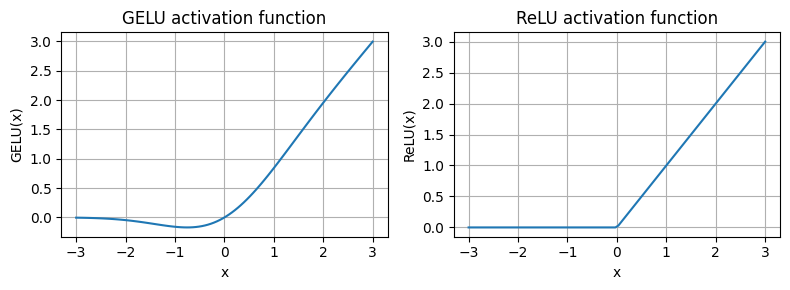

In [16]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
class FeedForward(nn.Module):
    def __init__(self, cfg: dict):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg.get("emb_dim"), 4 * cfg.get("emb_dim")),    # Expansion
            GELU(),                                                   # Activation
            nn.Linear(4 * cfg.get("emb_dim"), cfg.get("emb_dim")),    # Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [18]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
print(x)
out = ffn(x)
print(out)

tensor([[[0.7276, 0.4207, 0.9883,  ..., 0.5277, 0.3941, 0.4499],
         [0.7365, 0.6625, 0.2184,  ..., 0.7243, 0.9774, 0.3141],
         [0.2870, 0.1951, 0.9883,  ..., 0.6196, 0.2374, 0.5272]],

        [[0.1457, 0.2815, 0.1878,  ..., 0.7583, 0.6390, 0.1639],
         [0.3209, 0.9091, 0.7145,  ..., 0.2852, 0.1129, 0.0482],
         [0.3501, 0.0994, 0.2806,  ..., 0.7418, 0.3743, 0.1955]]])
tensor([[[-0.0032,  0.0101,  0.0707,  ..., -0.1144, -0.1848, -0.0301],
         [ 0.0635, -0.0454,  0.2409,  ..., -0.0672, -0.0761,  0.0165],
         [-0.0444, -0.0091,  0.0698,  ..., -0.1455, -0.0484,  0.0648]],

        [[-0.0493, -0.0202,  0.1517,  ..., -0.1655, -0.0959,  0.0955],
         [ 0.0377,  0.0021,  0.1138,  ..., -0.2026, -0.0334,  0.0547],
         [-0.0122,  0.0038,  0.0499,  ..., -0.1440, -0.0338,  0.0472]]],
       grad_fn=<ViewBackward0>)


## GPT ARCHITECTURE PART 4: SHORTCUT CONNECTIONS

In [19]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x += layer_output
            else:
                x = layer_output

        return x

In [20]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1, 0, -1]])
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print(model_without_shortcut)

ExampleDeepNeuralNetwork(
  (layers): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=3, out_features=3, bias=True)
      (1): GELU()
    )
    (4): Sequential(
      (0): Linear(in_features=3, out_features=1, bias=True)
      (1): GELU()
    )
  )
)


In [21]:
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print(model_with_shortcut)

ExampleDeepNeuralNetwork(
  (layers): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=3, out_features=3, bias=True)
      (1): GELU()
    )
    (4): Sequential(
      (0): Linear(in_features=3, out_features=1, bias=True)
      (1): GELU()
    )
  )
)


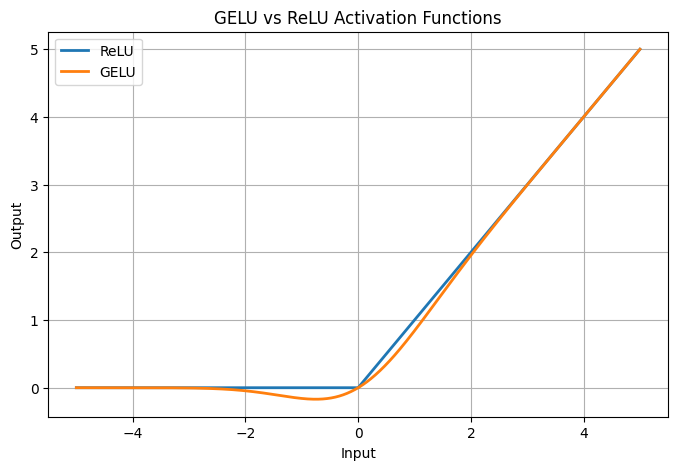

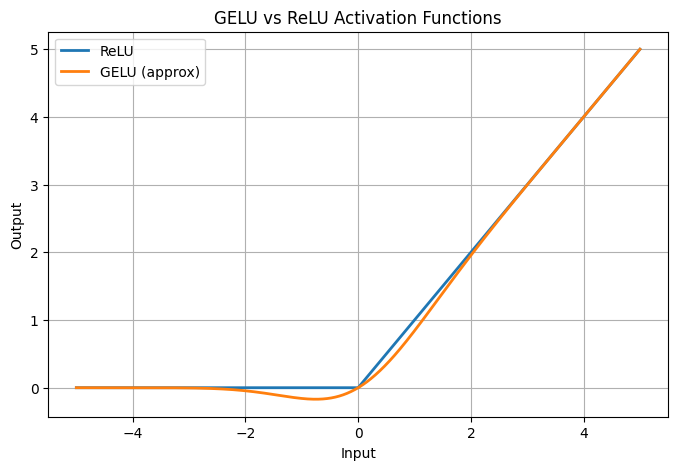

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf  # vectorized erf

# --- Activation Functions ---
def relu(x: np.ndarray) -> np.ndarray:
    """ReLU activation: max(0, x)"""
    return np.maximum(0, x)

def gelu(x: np.ndarray, approximate: bool = False) -> np.ndarray:
    """GELU activation with optional tanh approximation."""
    if approximate:
        return 0.5 * x * (1.0 + np.tanh(
            np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))
        ))
    else:
        return 0.5 * x * (1.0 + erf(x / np.sqrt(2.0)))

# --- Plot Comparison ---
def compare_activations(x_range=(-5, 5), num_points=1000, use_approx_gelu=False):
    x = np.linspace(x_range[0], x_range[1], num_points)
    y_relu = relu(x)
    y_gelu = gelu(x, approximate=use_approx_gelu)

    plt.figure(figsize=(8, 5))
    plt.plot(x, y_relu, label='ReLU', linewidth=2)
    plt.plot(x, y_gelu, label='GELU (approx)' if use_approx_gelu else 'GELU', linewidth=2)
    plt.title("GELU vs ReLU Activation Functions")
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    compare_activations(use_approx_gelu=False)  # Exact GELU
    compare_activations(use_approx_gelu=True)   # Approximate GELU


# ENTIRE TRANSFORMER BLOCK

In [24]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,       # Vocabulary size
    "context_length": 1024,    # Context length
    "emb_dim": 768,            # Embedding dimension
    "n_heads": 12,             # Number of attention heads
    "n_layers": 12,            # Number of layers
    "drop_rate": 0.1,          # Dropout rate
    "qkv_bias": False          # Query-Key-Value bias
}

In [25]:
class LayerNorm(nn.Module):
    def __init__(self, embeddings_dimension):
        super().__init__()
        self.epsilon = 1e-5
        self.scale = nn.Parameter(torch.ones(embeddings_dimension))
        self.shift = nn.Parameter(torch.zeros(embeddings_dimension))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        variance = x.var(dim=-1, keepdim=True, unbiased=False)
        normalized_x = (x - mean) / torch.sqrt(variance + self.epsilon)
        return self.scale * normalized_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))


class FeedForward(nn.Module):
    def __init__(self, cfg: dict):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg.get("emb_dim"), 4 * cfg.get("emb_dim")),    # Expansion
            GELU(),                                                   # Activation
            nn.Linear(4 * cfg.get("emb_dim"), cfg.get("emb_dim")),    # Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [26]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [27]:
class TransformerBlock(nn.Module):
    def __init__(self, config: dict):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_in=config.get("emb_dim"),
            d_out=config.get("emb_dim"),
            context_length=config.get("context_length"),
            num_heads=config.get("n_heads"),
            dropout=config.get("drop_rate"),
            qkv_bias=config.get("qkv_bias")
        )
        self.ff = FeedForward(config)
        self.norm1 = LayerNorm(config.get("emb_dim"))
        self.norm2 = LayerNorm(config.get("emb_dim"))
        self.drop_shortcut = nn.Dropout(config.get("drop_rate"))

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.attention(x)        # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut             # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

In [28]:
input = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

In [29]:
print(input)
print(output)

tensor([[[0.7224, 0.9756, 0.0540,  ..., 0.3062, 0.1647, 0.9737],
         [0.9469, 0.8493, 0.8168,  ..., 0.4267, 0.1530, 0.3325],
         [0.6370, 0.4886, 0.6477,  ..., 0.4020, 0.9052, 0.0407],
         [0.6619, 0.7961, 0.6245,  ..., 0.4797, 0.5558, 0.8601]],

        [[0.1168, 0.4356, 0.1781,  ..., 0.3164, 0.2556, 0.5046],
         [0.9171, 0.1967, 0.7479,  ..., 0.2387, 0.6476, 0.0155],
         [0.6820, 0.0778, 0.6835,  ..., 0.8527, 0.1366, 0.2587],
         [0.3879, 0.1475, 0.4469,  ..., 0.7588, 0.5391, 0.1742]]])
tensor([[[ 0.5100,  0.9005,  1.4294,  ...,  0.6368,  0.4392, -0.0408],
         [ 0.6963,  0.4468,  0.7552,  ...,  1.0700,  1.0859, -0.2169],
         [ 0.1341,  0.4008,  0.9112,  ...,  0.9545,  0.0934,  0.4561]],

        [[ 0.0855, -0.7275,  0.0330,  ...,  0.9041,  0.9583,  0.4150],
         [ 0.3014,  0.5994,  1.1162,  ..., -0.0553, -0.0149,  0.1894],
         [ 0.6483, -0.0807,  0.5259,  ...,  0.6382,  0.1809, -0.0212]]],
       grad_fn=<AddBackward0>)


In [30]:
class GPTModel(nn.Module):
    def __init__(self, cfg: dict):
        super().__init__()
        self.token_embedding = nn.Embedding(cfg.get("vocab_size"), cfg.get("emb_dim"))
        self.positional_embedding = nn.Embedding(cfg.get("context_length"), cfg.get("emb_dim"))
        self.drop_embeddings = nn.Dropout(cfg.get("drop_rate"))

        self.transformer_block = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg.get("n_layers"))]
        )

        self.final_norm = LayerNorm(cfg.get("emb_dim"))
        self.output_head = nn.Linear(
            cfg.get("emb_dim"), cfg.get("vocab_size"), bias=False
        )

    def forward(self, in_idx):
        batch_size, sequence_length = in_idx.shape
        token_embeddings = self.token_embedding(in_idx)
        position_embeddings = self.positional_embedding(torch.arange(sequence_length, device=in_idx.device))
        x = token_embeddings + position_embeddings
        x = self.drop_embeddings(x)
        x = self.transformer_block(x)
        x = self.final_norm(x)
        logits = self.output_head(x)

        return logits

In [34]:
batch = torch.tensor([
    [6109, 3626, 6100, 345],
    [6109, 1110, 6622, 257]
])
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [38]:
model = GPTModel(GPT_CONFIG_124M)
output = model(batch)
print(output)

tensor([[[ 0.1140,  0.0413,  0.5966,  ..., -0.4714,  0.7395, -0.5255],
         [ 0.3601, -0.0485,  0.1356,  ..., -0.2052, -0.0764,  0.2657],
         [-0.3504, -0.6792,  0.7037,  ..., -0.7343,  0.4669, -0.1421],
         [ 0.1518, -0.4081,  0.1005,  ..., -0.1630, -0.0946, -0.3596]],

        [[-0.3668, -0.6154,  0.9760,  ..., -0.5745,  0.5753, -0.2517],
         [ 0.6740, -0.5846, -0.4483,  ..., -0.1488, -1.0426, -0.2150],
         [-0.3537, -1.3954, -0.4690,  ..., -0.6459,  0.6142, -0.3559],
         [-0.3957, -0.0600, -0.4696,  ...,  0.3250, -0.0678,  0.0198]]],
       grad_fn=<UnsafeViewBackward0>)


In [39]:
print(output.shape)

torch.Size([2, 4, 50257])


In [40]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [42]:
print("Token embedding layer shape:", model.token_embedding.weight.shape)
print("Output layer shape:", model.output_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [43]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.output_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [44]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB
